In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data_preprocessed.csv")

In [3]:
data = data[data['functional_cd'] == 'Preapprove']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9025 entries, 5 to 18690
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 9025 non-null   int64  
 1   age                         8970 non-null   float64
 2   gender_cd                   8958 non-null   float64
 3   region_size                 5141 non-null   object 
 4   foreign_flg                 5141 non-null   float64
 5   entrepreneur_flg            5141 non-null   float64
 6   auto_flg                    5141 non-null   float64
 7   traveler_flg                5141 non-null   float64
 8   partnership_flg             5141 non-null   float64
 9   child_amt                   5141 non-null   float64
 10  realty_type                 5141 non-null   object 
 11  segment_cd                  5141 non-null   object 
 12  bundle_nm                   9025 non-null   object 
 13  confirmed_income            357 non-n

In [5]:
data['finish_dttm'] = pd.to_datetime(data['finish_dttm'])

In [6]:
data['weekday'] = data['finish_dttm'].dt.dayofweek
data['segment_number'] = data['segment_cd'].apply(lambda x: int(x.split()[0].split('_')[1]) if pd.notna(x) else x)

In [7]:
data[['finish_dttm', 'weekday', 'segment_cd', 'segment_number']].head()

,finish_dttm,weekday,segment_cd,segment_number
5,2023-11-24,4,t_07 (29),7.0
8,2022-07-27,2,t_08 (30),8.0
11,2023-04-19,2,NaN,NaN
13,2023-09-20,2,m_07 (18),7.0
14,2023-10-28,5,NaN,NaN


не берём колонки "confirmed_income", "predicted_income" и "emp_children_cnt"; так как слишком много пропусков и непонятно, как заполнять.

In [8]:
numeric_columns = ['customer_id', 'age', 'foreign_flg', 'entrepreneur_flg', 'auto_flg',
                   'traveler_flg', 'partnership_flg', 'child_amt', 'segment_number', 'weekday', 'state_talk_time_sec',
                   'employee_id', 'emp_age', 'emp_work_months_cnt']
numeric_data = data[numeric_columns]

In [9]:
clean_numeric_data = numeric_data.dropna()

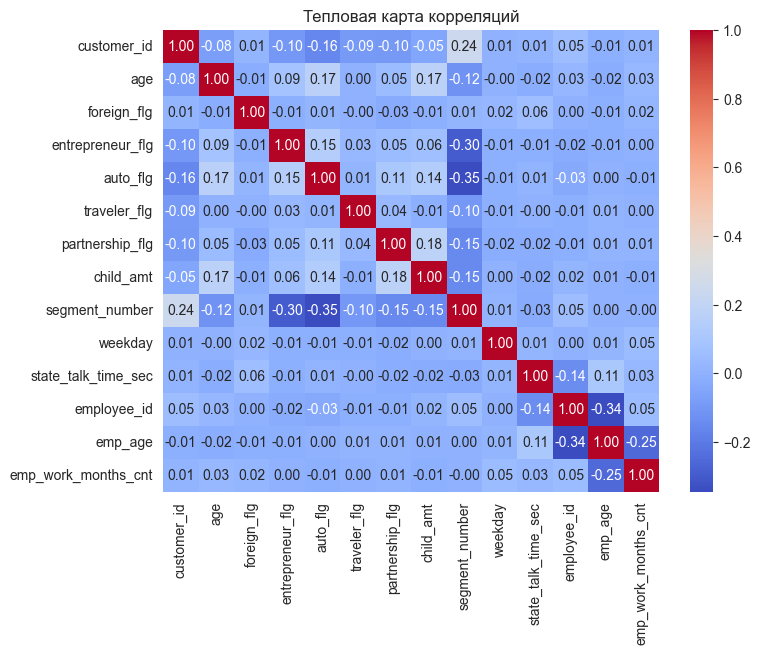

In [10]:
correlation_matrix = clean_numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

In [11]:
filled_numeric_data = numeric_data.copy()

In [12]:
flag_columns = ["foreign_flg", "entrepreneur_flg", 'auto_flg', "traveler_flg", 'partnership_flg', 'child_amt']

filled_numeric_data[flag_columns] = filled_numeric_data[flag_columns].fillna(0)
filled_numeric_data = filled_numeric_data.drop(columns=['segment_number'])
filled_numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9025 entries, 5 to 18690
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          9025 non-null   int64  
 1   age                  8971 non-null   float64
 2   foreign_flg          9025 non-null   float64
 3   entrepreneur_flg     9025 non-null   float64
 4   auto_flg             9025 non-null   float64
 5   traveler_flg         9025 non-null   float64
 6   partnership_flg      9025 non-null   float64
 7   child_amt            9025 non-null   float64
 8   weekday              9025 non-null   int32  
 9   state_talk_time_sec  9020 non-null   float64
 10  employee_id          9025 non-null   float64
 11  emp_age              9025 non-null   int64  
 12  emp_work_months_cnt  9025 non-null   int64  
dtypes: float64(9), int32(1), int64(3)
memory usage: 951.9 KB


In [13]:
filled_numeric_data = filled_numeric_data.dropna()

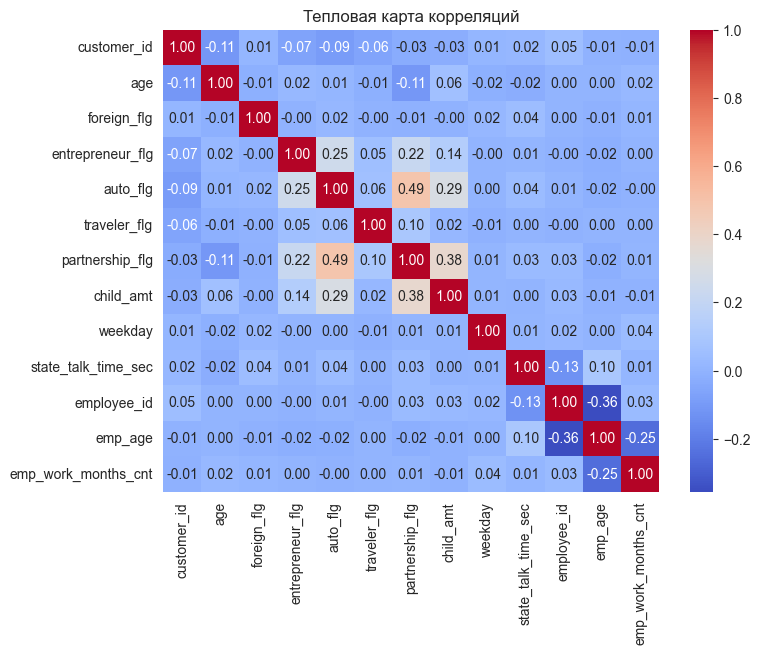

In [14]:
correlation_matrix_2 = filled_numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

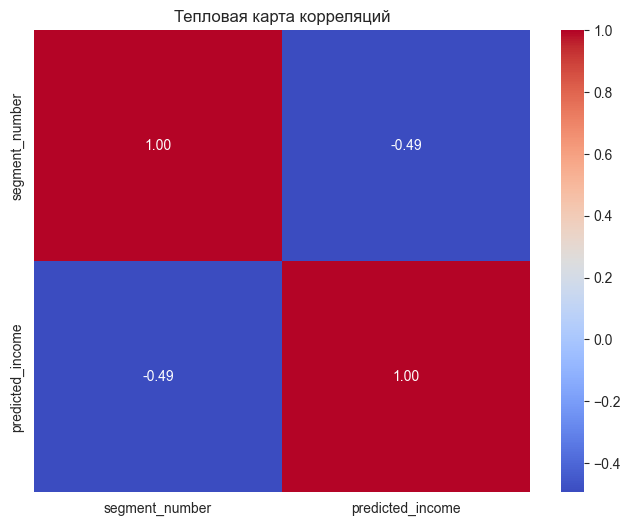

In [15]:
predicted_income_data = data[["segment_number", 'predicted_income']].dropna()

correlation_matrix_2 = predicted_income_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

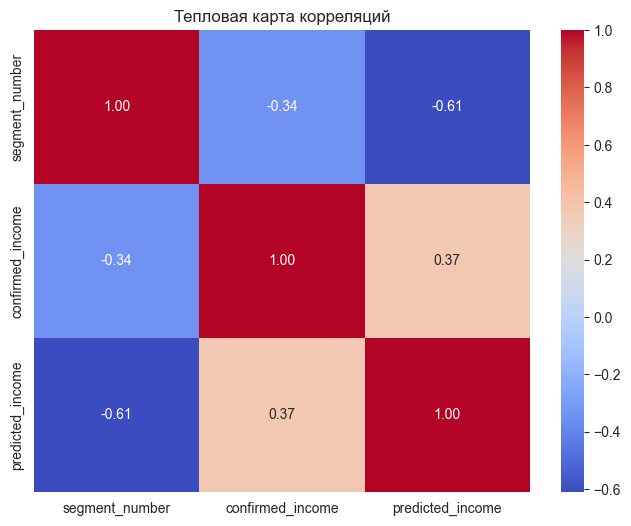

In [16]:
plt.show()
predicted_income_data = data[["segment_number", 'confirmed_income', 'predicted_income']].dropna()

correlation_matrix_2 = predicted_income_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

In [17]:
def get_cor_by_category(column):
    categories = data[column].unique()
    correlations_by_category = {}

    for category in categories:
        group_data = clean_numeric_data[data[column] == category]
        correlations_by_category[category] = group_data.corr()

    return correlations_by_category

In [18]:
cor_gender = get_cor_by_category('gender_cd')
cor_gender.keys()

C:\Users\Nikita Kazunin\AppData\Local\Temp\ipykernel_9520\2447178412.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_data = clean_numeric_data[data[column] == category]
C:\Users\Nikita Kazunin\AppData\Local\Temp\ipykernel_9520\2447178412.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_data = clean_numeric_data[data[column] == category]
C:\Users\Nikita Kazunin\AppData\Local\Temp\ipykernel_9520\2447178412.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_data = clean_numeric_data[data[column] == category]


dict_keys(['M', 'F', nan])

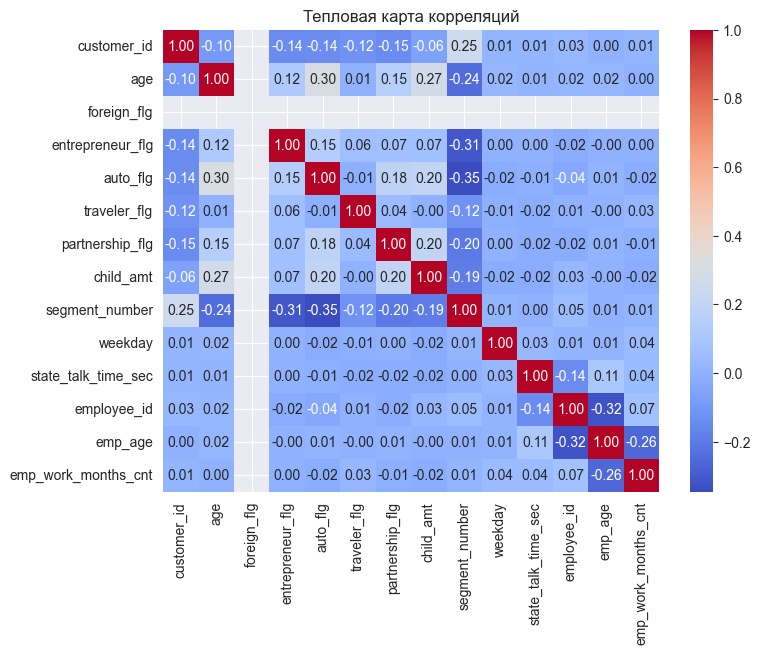

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cor_gender['M'], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

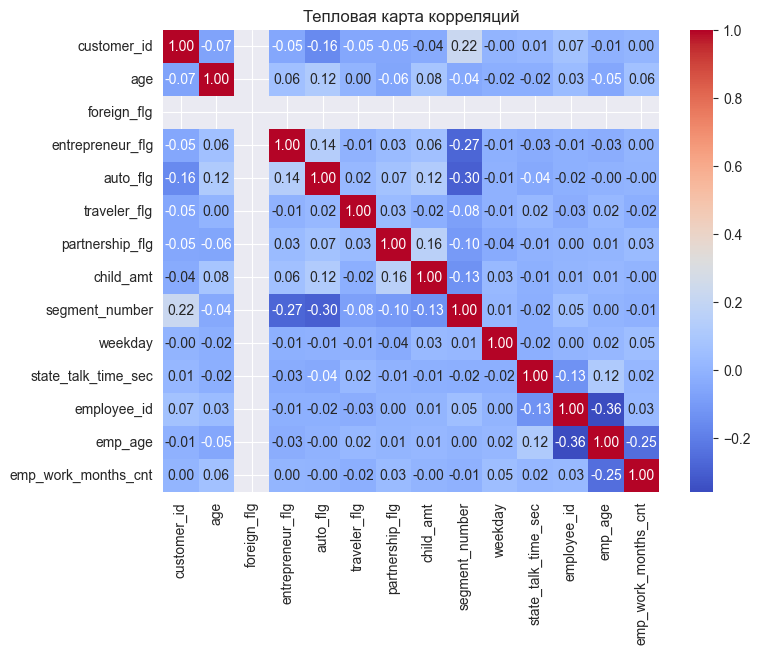

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(cor_gender['F'], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()

In [21]:
def get_cor_to_result(column):
    """Функция возвращает корреляцию к результату звонка от подаваемого признака"""
    unique_combinations = data.groupby([column, 'wo_hit_status_result_desc']).size().unstack()
    unique_combinations['total'] = unique_combinations['Дозвон, Отказ'] + unique_combinations['Дозвон, Успешно']
    unique_combinations['ratio_false'] = unique_combinations['Дозвон, Отказ'] / unique_combinations['total']
    unique_combinations['ratio_true'] = unique_combinations['Дозвон, Успешно'] / unique_combinations['total']
    return unique_combinations

C:\Users\Nikita Kazunin\AppData\Local\Temp\ipykernel_25804\1264572802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'age': 'Возраст клиента', 'gender_cd': 'Пол клиента', 'foreign_flg': 'Флаг иностранного гражданина', 'traveler_flg': 'Флаг путешественника', 'partnership_flg': 'Флаг наличия партнёра', 'confirmed_income': 'Подтверждённый доход', 'state_talk_time_sec': ' Длительность звонка', 'child_amt': 'Кол-во детей, проживающих с клиентом', 'emp_age': 'Возраст сотрудника'}, inplace=True)


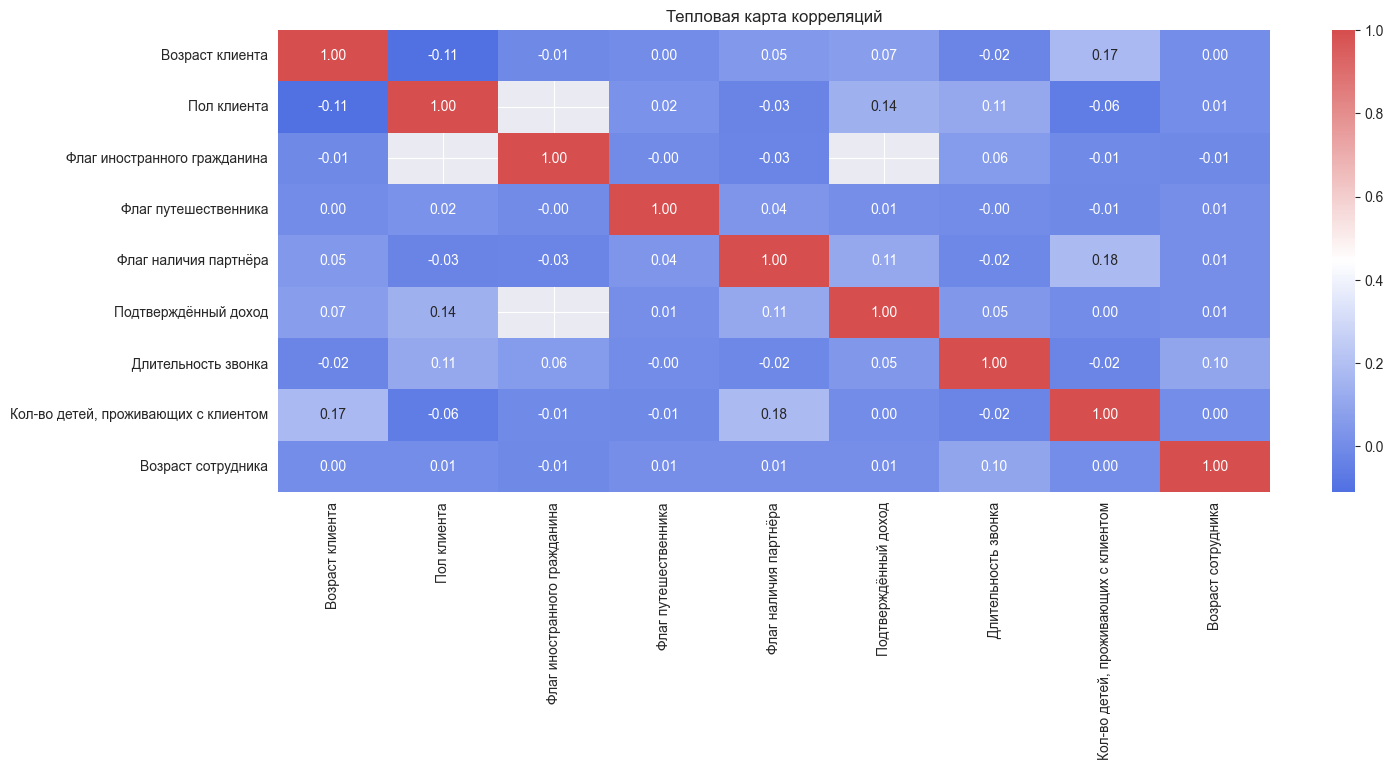

In [9]:
import matplotlib.colors as mcolors

colors = ["#5170E2", "#FFFFFF", "#D64E4E"]

cmap_name = "custom_cmap"
cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

df1 = data[['age', 'gender_cd', 'foreign_flg', 'traveler_flg', 'partnership_flg', 'confirmed_income', 'state_talk_time_sec', 'child_amt', 'emp_age']]
df1.rename(columns={'age': 'Возраст клиента', 'gender_cd': 'Пол клиента', 'foreign_flg': 'Флаг иностранного гражданина', 'traveler_flg': 'Флаг путешественника', 'partnership_flg': 'Флаг наличия партнёра', 'confirmed_income': 'Подтверждённый доход', 'state_talk_time_sec': ' Длительность звонка', 'child_amt': 'Кол-во детей, проживающих с клиентом', 'emp_age': 'Возраст сотрудника'}, inplace=True)
correlation_matrix = df1.corr(numeric_only=True)

plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f")
plt.title("Тепловая карта корреляций")
plt.show()